In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# CNN_LSTM

#### Read Cleaned Data

In [58]:
oba_cleanall = np.load('./TrainData/tweets_oba.npy', allow_pickle=True)
targets_oba = np.load('./TrainData/targets_oba.npy', allow_pickle=True)
rom_cleanall = np.load('./TrainData/tweets_rom.npy', allow_pickle=True)
targets_rom = np.load('./TrainData/targets_rom.npy', allow_pickle=True)
df_oba = pd.DataFrame({'tweet':oba_cleanall, 'label': targets_oba })
df_rom = pd.DataFrame({'tweet':rom_cleanall, 'label': targets_rom })

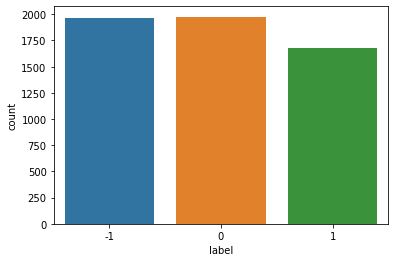

In [59]:
sns.countplot(df_oba['label'])

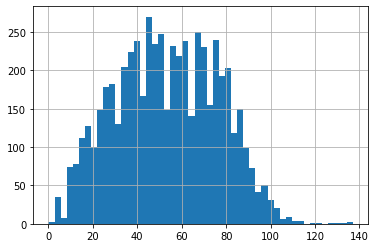

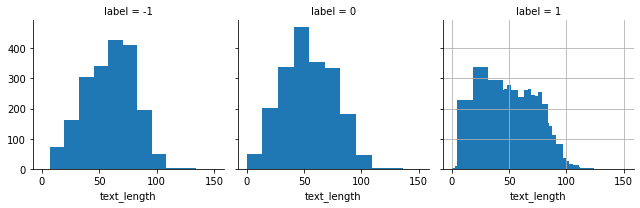

In [60]:
df_oba['text_length'] = df_oba['tweet'].apply(len)
df_oba[['label','text_length','tweet']].head()
df_oba['text_length'].describe()
df_oba['text_length'].hist(bins=50)
g = sns.FacetGrid(df_oba,col='label')
g.map(plt.hist,'text_length')

df_rom['text_length'] = df_rom['tweet'].apply(len)
df_rom[['label','text_length','tweet']].head()
df_rom['text_length'].describe()
df_rom['text_length'].hist(bins=50)
# g = sns.FacetGrid(df_rom,col='label')
# g.map(plt.hist,'text_length')


#### Data Preprocessing


In [61]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_oba['tweet'], df_oba['label'],
                                                    test_size=0.2,
                                                    stratify=df_oba['label'],
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4499,) (1125,) (4499,) (1125,)


In [62]:
# Tokenize Text
from keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

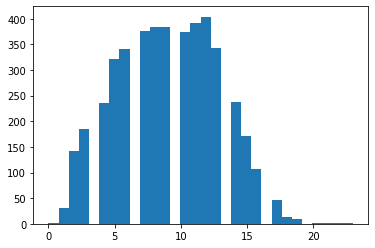

In [63]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()


In [64]:
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
max_words = 30
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print(y_train.shape,y_test.shape)

(4499, 30) (1125, 30)
(4499, 3) (1125, 3)


#### CNN-LSTM

In [65]:
batch_size = 128
epochs = 5
num_classes = 3

def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [66]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=epochs, batch_size=batch_size, verbose=2)
    print(model_history.history)
    # plot train history
    plot_model_history(model_history)

In [67]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [68]:
def model_evaluate():
    # predict class with test set
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))

    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 3)                 3

<ipython-input-67-488f151b518c>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-67-488f151b518c>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


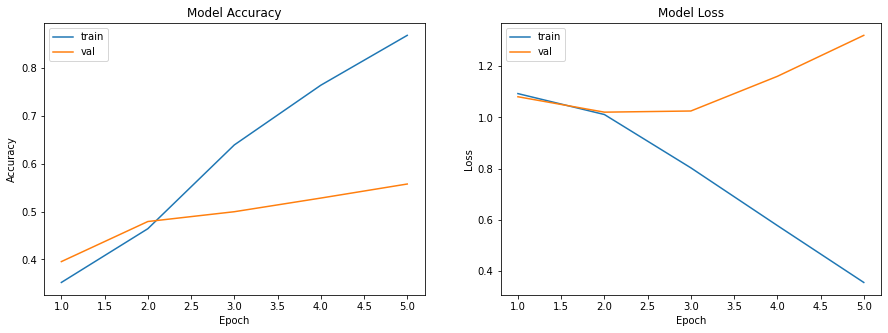

In [69]:
# train the model
max_features = 20000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	55.7%


              precision    recall  f1-score   support

           0       0.52      0.47      0.50       395
           1       0.54      0.65      0.59       336
           2       0.61      0.57      0.59       394

    accuracy                           0.56      1125
   macro avg       0.56      0.56      0.56      1125
weighted avg       0.56      0.56      0.56      1125



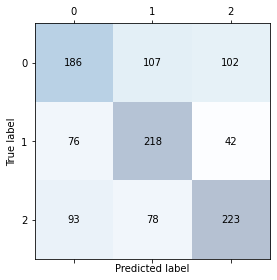

In [70]:
model_evaluate()